In [1]:
%reset -f

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


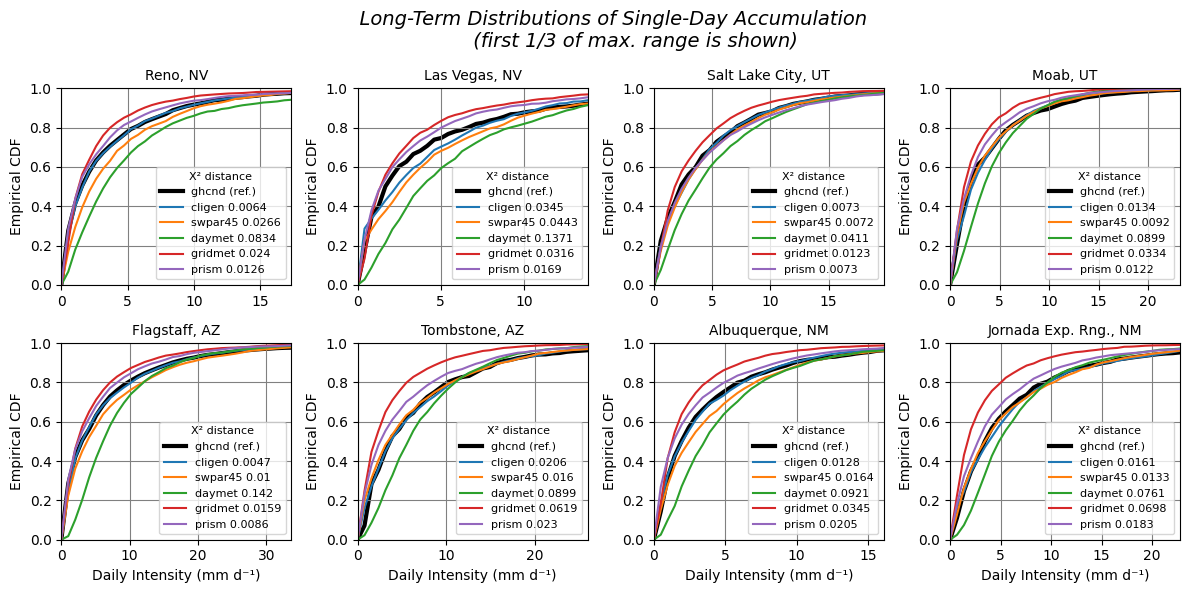

accum_dists
cligen swpar45 daymet gridmet prism
[np.float64(0.014475000000000002), np.float64(0.017875), np.float64(0.09394999999999998), np.float64(0.035425), np.float64(0.014925)]


In [3]:

import pandas as pd
import numpy as np
import scipy
from scipy.spatial import distance
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import os
from decimal import Decimal

dataDIR = '/content/drive/My Drive/Colab Notebooks/GHCNd'
saveFILE = '/content/drive/My Drive/GEE_Downloads/Fig7.jpg'


def chi2_distance(A, B):
  chi = 0.5 * np.sum([((a - b)**2) / (a + b)
                    for (a, b) in zip(A, B)])
  return chi

lvlOneFolders = ['rn', 'lv', 'sl', 'mb', 'fs', 'tb', 'ab', 'jd']
labels = ['Reno, NV', 'Las Vegas, NV', 'Salt Lake City, UT', 'Moab, UT', 'Flagstaff, AZ', 'Tombstone, AZ', 'Albuquerque, NM', 'Jornada Exp. Rng., NM']

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
plt.rcParams['axes.grid'] = True
dataset_dists = []
ax_inds = [[0,0], [0,1], [0,2], [0,3], [1,0], [1,1], [1,2], [1,3]]
for i, ax in enumerate(axs.reshape(-1)):

  lvlOneFolder = lvlOneFolders[i]

  files = os.listdir(os.path.join(dataDIR, lvlOneFolder))

  for f in files:
    if '_cligen.csv' in f:
      cligen_file = f
    elif '_swpar45.txt' in f:
      swpar45_file = f
    elif '_ghcnd.csv' in f:
      ghcnd_file = f
    elif '_daymet.csv' in f:
      daymet_file = f
    elif '_gridmet.csv' in f:
      gridmet_file = f
    elif '_prism.csv' in f:
      prism_file = f
    elif '_maca.csv' in f:
      maca_file = f
    else:
      pass

  with open(os.path.join(dataDIR, lvlOneFolder, cligen_file)) as f:
    lines = f.readlines()
    p = [float(l.split()[3]) for l in lines[15:-1] if float(l.split()[3]) > 0.0]
    cligen_p = p

  with open(os.path.join(dataDIR, lvlOneFolder, swpar45_file)) as f:
    lines = f.readlines()
    p = [float(l.split()[3]) for l in lines[15:-1] if float(l.split()[3]) > 0.0]
    swpar45_p = p

  with open(os.path.join(dataDIR, lvlOneFolder, ghcnd_file)) as f:
    lines = f.readlines()
    p = [float(l.split(',')[4]) for l in lines[1:] if float(l.split(',')[4]) > 0.0]
    ghcnd_p = p

  with open(os.path.join(dataDIR, lvlOneFolder, daymet_file)) as f:
    lines = f.readlines()
    p = [float(l.split(',')[1]) for l in lines[1:] if float(l.split(',')[1]) > 0.0]
    daymet_p = p

  with open(os.path.join(dataDIR, lvlOneFolder, gridmet_file)) as f:
    lines = f.readlines()
    p = [float(l.split(',')[1]) for l in lines[1:] if float(l.split(',')[1]) > 0.0]
    gridmet_p = p

  with open(os.path.join(dataDIR, lvlOneFolder, prism_file)) as f:
    lines = f.readlines()
    p = [float(l.split(',')[1]) for l in lines[1:] if float(l.split(',')[1]) > 0.0]
    prism_p = p

  #with open(os.path.join(dataDIR, lvlOneFolder, maca_file)) as f:
  #  lines = f.readlines()
  #  p = [float(l.split(',')[1]) for l in lines[1:] if float(l.split(',')[1]) > 0.0]
  #  maca_p = p

  max_value = max(max(cligen_p), max(swpar45_p), max(ghcnd_p), max(daymet_p), max(gridmet_p), max(prism_p))
  min_value = min(min(cligen_p), max(swpar45_p), min(ghcnd_p), min(daymet_p), min(gridmet_p), min(prism_p))

  bins_pdf = np.linspace(min_value, max_value, 51)

  cligen_h = np.array(np.histogram(cligen_p, bins_pdf)[0], float)
  swpar45_h = np.array(np.histogram(swpar45_p, bins_pdf)[0], float)
  ghcnd_h = np.array(np.histogram(ghcnd_p, bins_pdf)[0], float)
  daymet_h = np.array(np.histogram(daymet_p, bins_pdf)[0], float)
  gridmet_h = np.array(np.histogram(gridmet_p, bins_pdf)[0], float)
  prism_h = np.array(np.histogram(prism_p, bins_pdf)[0], float)
  #maca_h = np.array(np.histogram(maca_p, bins_pdf)[0], float)

  cligen_h[cligen_h == 0] = 1e-9
  swpar45_h[swpar45_h == 0] = 1e-9
  ghcnd_h[ghcnd_h == 0] = 1e-9
  daymet_h[daymet_h == 0] = 1e-9
  gridmet_h[gridmet_h == 0] = 1e-9
  prism_h[prism_h == 0] = 1e-9
  #maca_h[maca_h == 0] = 1e-9

  cligen_pdf = np.array([count/len(cligen_p) for i, count in enumerate(cligen_h)])
  swpar45_pdf = np.array([count/len(swpar45_p) for i, count in enumerate(swpar45_h)])
  ghcnd_pdf = np.array([count/len(ghcnd_p) for i, count in enumerate(ghcnd_h)])
  daymet_pdf = np.array([count/len(daymet_p) for i, count in enumerate(daymet_h)])
  gridmet_pdf = np.array([count/len(gridmet_p) for i, count in enumerate(gridmet_h)])
  prism_pdf = np.array([count/len(prism_p) for i, count in enumerate(prism_h)])
  #maca_pdf = np.array([count/len(maca_p) for i, count in enumerate(maca_h)])

  cligen_dev = round(chi2_distance(ghcnd_pdf, cligen_pdf), 4)
  swpar45_dev = round(chi2_distance(ghcnd_pdf, swpar45_pdf), 4)
  daymet_dev = round(chi2_distance(ghcnd_pdf, daymet_pdf), 4)
  gridmet_dev = round(chi2_distance(ghcnd_pdf, gridmet_pdf), 4)
  prism_dev = round(chi2_distance(ghcnd_pdf, prism_pdf), 4)
  #maca_dev = round(chi2_distance(ghcnd_pdf, maca_pdf), 4)

  bins_cdf = np.linspace(min_value, max_value, 101)

  cligen_h = np.array(np.histogram(cligen_p, bins_cdf)[0], float)
  swpar45_h = np.array(np.histogram(swpar45_p, bins_cdf)[0], float)
  ghcnd_h = np.array(np.histogram(ghcnd_p, bins_cdf)[0], float)
  daymet_h = np.array(np.histogram(daymet_p, bins_cdf)[0], float)
  gridmet_h = np.array(np.histogram(gridmet_p, bins_cdf)[0], float)
  prism_h = np.array(np.histogram(prism_p, bins_cdf)[0], float)
  #maca_h = np.array(np.histogram(maca_p, bins_cdf)[0], float)

  cligen_cdf = np.array([0.0] + [sum(cligen_h[:i+1])/len(cligen_p) for i, value in enumerate(cligen_h)])
  swpar45_cdf = np.array([0.0] + [sum(swpar45_h[:i+1])/len(swpar45_p) for i, value in enumerate(swpar45_h)])
  ghcnd_cdf = np.array([0.0] + [sum(ghcnd_h[:i+1])/len(ghcnd_p) for i, value in enumerate(ghcnd_h)])
  daymet_cdf = np.array([0.0] + [sum(daymet_h[:i+1])/len(daymet_p) for i, value in enumerate(daymet_h)])
  gridmet_cdf = np.array([0.0] + [sum(gridmet_h[:i+1])/len(gridmet_p) for i, value in enumerate(gridmet_h)])
  prism_cdf = np.array([0.0] + [sum(prism_h[:i+1])/len(prism_p) for i, value in enumerate(prism_h)])
  #maca_cdf = np.array([0.0] + [sum(maca_h[:i+1])/len(maca_p) for i, value in enumerate(maca_h)])

  ghcnd, = ax.plot(bins_cdf, ghcnd_cdf, color='black', linewidth=3, zorder=-999)
  cligen, = ax.plot(bins_cdf, cligen_cdf)
  swpar45, = ax.plot(bins_cdf, swpar45_cdf)
  daymet, = ax.plot(bins_cdf, daymet_cdf)
  gridmet, = ax.plot(bins_cdf, gridmet_cdf)
  prism, = ax.plot(bins_cdf, prism_cdf)
  #maca, = ax.plot(bins_cdf, maca_cdf)
  ax.set_title(labels[i], fontsize=10)
  ax.legend([ghcnd, cligen, swpar45, daymet, gridmet, prism], ['ghcnd (ref.)', 'cligen {}'.format(str(cligen_dev)), 'swpar45 {}'.format(str(swpar45_dev)), 'daymet {}'.format(str(daymet_dev)), 'gridmet {}'.format(str(gridmet_dev)), 'prism {}'.format(str(prism_dev))], loc='lower right', fontsize=8, markerscale=0.5, title_fontsize=8, title='X² distance')
  ax.set_xlim(0, 0.33*max_value)
  ax.set_ylim(0, 1)
  ax.set_ylabel('Empirical CDF')
  if i > 3:
    ax.set_xlabel('Daily Intensity (mm d⁻¹)')
  ax.grid(color='gray')

  dataset_dists.append([cligen_dev, swpar45_dev, daymet_dev, gridmet_dev, prism_dev])

plt.suptitle('      Long-Term Distributions of Single-Day Accumulation\n             (first 1/3 of max. range is shown)', size=14, fontstyle='oblique')
ax.grid(color='gray')
plt.tight_layout()
plt.show()

fig.savefig(saveFILE, dpi=600, bbox_inches='tight')

dataset_avg_dists = []
for i in range(5):
  d = 0
  for j, label in enumerate(labels):
    d += dataset_dists[j][i]
  dataset_avg_dists.append(d/len(labels))

print('accum_dists')
print('cligen swpar45 daymet gridmet prism')
print(dataset_avg_dists)


In [ ]:
%reset -f


1974.txt
2020.txt
2040.txt
az028820.txt
2000.txt
2010.txt
2030.txt
2050.txt
2060.txt
2070.txt


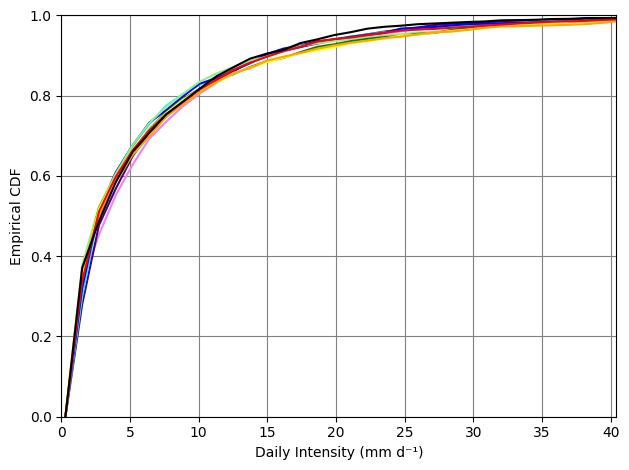

In [ ]:

import pandas as pd
import numpy as np
import scipy
from scipy.spatial import distance
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import os
from decimal import Decimal

dataDIR = '/content/drive/My Drive/Colab Notebooks/FigureCDFChange/Tucson/CLIGEN_output'
saveFILE = '/content/drive/My Drive/GEE_Downloads/Fig_cdf_change_Tucson.jpg'


def chi2_distance(A, B):
  chi = 0.5 * np.sum([((a - b)**2) / (a + b)
                    for (a, b) in zip(A, B)])
  return chi


labels = ['US CLIGEN Net.', 'SWPar4.5 1974-2013', 'SWPar4.5 2000-2029', 'SWPar4.5 2010-2039', 'SWPar4.5 2020-2049', 'SWPar4.5 2030-2059', 'SWPar4.5 2040-2069', 'SWPar4.5 2050-2079', 'SWPar4.5 2060-2089', 'SWPar4.5 2070-2099']

ax = plt.subplot()
plt.rcParams['axes.grid'] = True

for f in os.listdir(dataDIR):
  print(f)
  if 'az' in f:
    cligen_file = f
  #elif '_ghcnd.csv' in f:
  #  ghcnd_file = f
  elif '1974' in f:
    a_file = f
  elif '2000' in f:
    b_file = f
  elif '2010' in f:
    c_file = f
  elif '2020' in f:
    d_file = f
  elif '2030' in f:
    e_file = f
  elif '2040' in f:
    f_file = f
  elif '2050' in f:
    g_file = f
  elif '2060' in f:
    h_file = f
  elif '2070' in f:
    i_file = f
  else:
    pass

with open(os.path.join(dataDIR, cligen_file)) as f:
  lines = f.readlines()
  p = [float(l.split()[3]) for l in lines[15:-1] if float(l.split()[3]) > 0.0]
  cligen_p = p

# with open(os.path.join(dataDIR, lvlOneFolder, ghcnd_file)) as f:
#   lines = f.readlines()
#   p = [float(l.split(',')[4]) for l in lines[1:] if float(l.split(',')[4]) > 0.0]
#   ghcnd_p = p

with open(os.path.join(dataDIR, a_file)) as f:
  lines = f.readlines()
  p = [float(l.split()[3]) for l in lines[15:-1] if float(l.split()[3]) > 0.0]
  a_p = p

with open(os.path.join(dataDIR, b_file)) as f:
  lines = f.readlines()
  p = [float(l.split()[3]) for l in lines[15:-1] if float(l.split()[3]) > 0.0]
  b_p = p

with open(os.path.join(dataDIR, c_file)) as f:
  lines = f.readlines()
  p = [float(l.split()[3]) for l in lines[15:-1] if float(l.split()[3]) > 0.0]
  c_p = p

with open(os.path.join(dataDIR, d_file)) as f:
  lines = f.readlines()
  p = [float(l.split()[3]) for l in lines[15:-1] if float(l.split()[3]) > 0.0]
  d_p = p

with open(os.path.join(dataDIR, e_file)) as f:
  lines = f.readlines()
  p = [float(l.split()[3]) for l in lines[15:-1] if float(l.split()[3]) > 0.0]
  e_p = p

with open(os.path.join(dataDIR, f_file)) as f:
  lines = f.readlines()
  p = [float(l.split()[3]) for l in lines[15:-1] if float(l.split()[3]) > 0.0]
  f_p = p

with open(os.path.join(dataDIR, g_file)) as f:
  lines = f.readlines()
  p = [float(l.split()[3]) for l in lines[15:-1] if float(l.split()[3]) > 0.0]
  g_p = p

with open(os.path.join(dataDIR, h_file)) as f:
  lines = f.readlines()
  p = [float(l.split()[3]) for l in lines[15:-1] if float(l.split()[3]) > 0.0]
  h_p = p

with open(os.path.join(dataDIR, i_file)) as f:
  lines = f.readlines()
  p = [float(l.split()[3]) for l in lines[15:-1] if float(l.split()[3]) > 0.0]
  i_p = p



# max_value = max(max(cligen_p), max(ghcnd_p), max(daymet_p), max(gridmet_p), max(prism_p))
# min_value = min(min(cligen_p), min(ghcnd_p), min(daymet_p), min(gridmet_p), min(prism_p))
max_value = max(max(cligen_p), max(a_p), max(b_p), max(c_p), max(d_p), max(e_p), max(f_p), max(g_p), max(h_p), max(i_p))
min_value = min(min(cligen_p), min(a_p), min(b_p), min(c_p), min(d_p), max(e_p), max(f_p), max(g_p), max(h_p), max(i_p))


bins_pdf = np.linspace(min_value, max_value, 51)

cligen_h = np.array(np.histogram(cligen_p, bins_pdf)[0], float)
#ghcnd_h = np.array(np.histogram(ghcnd_p, bins_pdf)[0], float)
a_h = np.array(np.histogram(a_p, bins_pdf)[0], float)
b_h = np.array(np.histogram(b_p, bins_pdf)[0], float)
c_h = np.array(np.histogram(c_p, bins_pdf)[0], float)
d_h = np.array(np.histogram(d_p, bins_pdf)[0], float)
e_h = np.array(np.histogram(e_p, bins_pdf)[0], float)
f_h = np.array(np.histogram(f_p, bins_pdf)[0], float)
g_h = np.array(np.histogram(g_p, bins_pdf)[0], float)
h_h = np.array(np.histogram(h_p, bins_pdf)[0], float)
i_h = np.array(np.histogram(i_p, bins_pdf)[0], float)

cligen_h[cligen_h == 0] = 1e-9
#ghcnd_h[ghcnd_h == 0] = 1e-9
a_h[a_h == 0] = 1e-9
b_h[b_h == 0] = 1e-9
c_h[c_h == 0] = 1e-9
d_h[d_h == 0] = 1e-9
e_h[e_h == 0] = 1e-9
f_h[f_h == 0] = 1e-9
g_h[g_h == 0] = 1e-9
h_h[h_h == 0] = 1e-9
i_h[i_h == 0] = 1e-9



cligen_pdf = np.array([count/len(cligen_p) for i, count in enumerate(cligen_h)])
#ghcnd_pdf = np.array([count/len(ghcnd_p) for i, count in enumerate(ghcnd_h)])
a_pdf = np.array([count/len(a_p) for i, count in enumerate(a_h)])
b_pdf = np.array([count/len(b_p) for i, count in enumerate(b_h)])
c_pdf = np.array([count/len(c_p) for i, count in enumerate(c_h)])
d_pdf = np.array([count/len(d_p) for i, count in enumerate(d_h)])
e_pdf = np.array([count/len(e_p) for i, count in enumerate(e_h)])
f_pdf = np.array([count/len(f_p) for i, count in enumerate(f_h)])
g_pdf = np.array([count/len(g_p) for i, count in enumerate(g_h)])
h_pdf = np.array([count/len(h_p) for i, count in enumerate(h_h)])
i_pdf = np.array([count/len(i_p) for i, count in enumerate(i_h)])


# cligen_dev = round(chi2_distance(ghcnd_pdf, cligen_pdf), 4)
# a_dev = round(chi2_distance(a_pdf, a_pdf), 4)
# b_dev = round(chi2_distance(b_pdf, b_pdf), 4)
# c_dev = round(chi2_distance(c_pdf, c_pdf), 4)
# d_dev = round(chi2_distance(d_pdf, d_pdf), 4)
# e_dev = round(chi2_distance(e_pdf, e_pdf), 4)
# f_dev = round(chi2_distance(f_pdf, f_pdf), 4)
# g_dev = round(chi2_distance(g_pdf, g_pdf), 4)
# h_dev = round(chi2_distance(h_pdf, h_pdf), 4)
# i_dev = round(chi2_distance(i_pdf, i_pdf), 4)

bins_cdf = np.linspace(min_value, max_value, 101)

cligen_h = np.array(np.histogram(cligen_p, bins_cdf)[0], float)
#ghcnd_h = np.array(np.histogram(ghcnd_p, bins_pdf)[0], float)
a_h = np.array(np.histogram(a_p, bins_cdf)[0], float)
b_h = np.array(np.histogram(b_p, bins_cdf)[0], float)
c_h = np.array(np.histogram(c_p, bins_cdf)[0], float)
d_h = np.array(np.histogram(d_p, bins_cdf)[0], float)
e_h = np.array(np.histogram(e_p, bins_cdf)[0], float)
f_h = np.array(np.histogram(f_p, bins_cdf)[0], float)
g_h = np.array(np.histogram(g_p, bins_cdf)[0], float)
h_h = np.array(np.histogram(h_p, bins_cdf)[0], float)
i_h = np.array(np.histogram(i_p, bins_cdf)[0], float)

cligen_cdf = np.array([0.0] + [sum(cligen_h[:i+1])/len(cligen_p) for i, value in enumerate(cligen_h)])
#ghcnd_cdf = np.array([0.0] + [sum(ghcnd_h[:i+1])/len(ghcnd_p) for i, value in enumerate(ghcnd_h)])
a_cdf = np.array([0.0] + [sum(a_h[:i+1])/len(a_p) for i, value in enumerate(a_h)])
b_cdf = np.array([0.0] + [sum(b_h[:i+1])/len(b_p) for i, value in enumerate(b_h)])
c_cdf = np.array([0.0] + [sum(c_h[:i+1])/len(c_p) for i, value in enumerate(c_h)])
d_cdf = np.array([0.0] + [sum(d_h[:i+1])/len(d_p) for i, value in enumerate(d_h)])
e_cdf = np.array([0.0] + [sum(e_h[:i+1])/len(e_p) for i, value in enumerate(e_h)])
f_cdf = np.array([0.0] + [sum(f_h[:i+1])/len(f_p) for i, value in enumerate(f_h)])
g_cdf = np.array([0.0] + [sum(g_h[:i+1])/len(g_p) for i, value in enumerate(g_h)])
h_cdf = np.array([0.0] + [sum(h_h[:i+1])/len(h_p) for i, value in enumerate(h_h)])
i_cdf = np.array([0.0] + [sum(i_h[:i+1])/len(i_p) for i, value in enumerate(i_h)])

#ghcnd, = ax.plot(bins_cdf, ghcnd_cdf, color='black', linewidth=2, zorder=-999)
cligen, = ax.plot(bins_cdf, cligen_cdf, c='black', zorder=999)
a, = ax.plot(bins_cdf, a_cdf, c='violet')
b, = ax.plot(bins_cdf, b_cdf, c='indigo')
c, = ax.plot(bins_cdf, c_cdf, c='cyan')
d, = ax.plot(bins_cdf, d_cdf, c='blue')
e, = ax.plot(bins_cdf, e_cdf, c='lightgreen')
f, = ax.plot(bins_cdf, f_cdf, c='green')
g, = ax.plot(bins_cdf, g_cdf, c='yellow')
h, = ax.plot(bins_cdf, h_cdf, c='orange')
i, = ax.plot(bins_cdf, i_cdf, c='red')

#ax.legend([ghcnd, a, b, c, d, e, f, g, h, i], ['ghcnd (ref.)', 'cligen {}'.format(str(cligen_dev)), 'daymet {}'.format(str(daymet_dev)), 'gridmet {}'.format(str(gridmet_dev)), 'prism {}'.format(str(prism_dev))], loc='lower right', title=labels[i] + ' | X² dist.')
ax.set_xlim(0, 0.33*max_value)
#ax.set_xlim(10, 30)
ax.set_ylim(0, 1)
ax.set_ylabel('Empirical CDF')
ax.set_xlabel('Daily Intensity (mm d⁻¹)')
ax.grid(color='gray')

#axs[0,1].set_title('Long-Term Distributions of Single-Day Accumulation\n(first 1/3 of max. range is shown)', size=14, fontstyle='oblique', pad=20)
ax.grid(color='gray')
plt.tight_layout()
plt.show()

#fig.savefig(saveFILE, dpi=600, bbox_inches='tight')




In [ ]:
%reset -f


2030.txt
2060.txt
2040.txt
2050.txt
2010.txt
1974.txt
2070.txt
2020.txt
az023010.txt
2000.txt


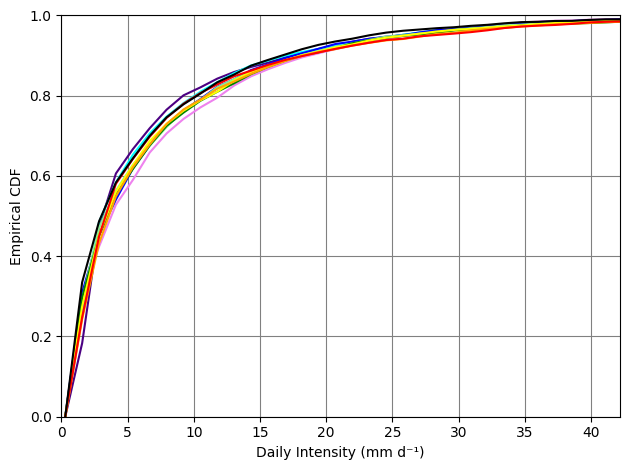

In [ ]:

import pandas as pd
import numpy as np
import scipy
from scipy.spatial import distance
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import os
from decimal import Decimal

dataDIR = '/content/drive/My Drive/Colab Notebooks/FigureCDFChange/Flagstaff/CLIGEN_output'
saveFILE = '/content/drive/My Drive/GEE_Downloads/Fig_cdf_change_Flagstaff.jpg'


def chi2_distance(A, B):
  chi = 0.5 * np.sum([((a - b)**2) / (a + b)
                    for (a, b) in zip(A, B)])
  return chi


labels = ['US CLIGEN Net.', 'SWPar4.5 1974-2013', 'SWPar4.5 2000-2029', 'SWPar4.5 2010-2039', 'SWPar4.5 2020-2049', 'SWPar4.5 2030-2059', 'SWPar4.5 2040-2069', 'SWPar4.5 2050-2079', 'SWPar4.5 2060-2089', 'SWPar4.5 2070-2099']

ax = plt.subplot()
plt.rcParams['axes.grid'] = True

for f in os.listdir(dataDIR):
  print(f)
  if 'az' in f:
    cligen_file = f
  #elif '_ghcnd.csv' in f:
  #  ghcnd_file = f
  elif '1974' in f:
    a_file = f
  elif '2000' in f:
    b_file = f
  elif '2010' in f:
    c_file = f
  elif '2020' in f:
    d_file = f
  elif '2030' in f:
    e_file = f
  elif '2040' in f:
    f_file = f
  elif '2050' in f:
    g_file = f
  elif '2060' in f:
    h_file = f
  elif '2070' in f:
    i_file = f
  else:
    pass

with open(os.path.join(dataDIR, cligen_file)) as f:
  lines = f.readlines()
  p = [float(l.split()[3]) for l in lines[15:-1] if float(l.split()[3]) > 0.0]
  cligen_p = p

# with open(os.path.join(dataDIR, lvlOneFolder, ghcnd_file)) as f:
#   lines = f.readlines()
#   p = [float(l.split(',')[4]) for l in lines[1:] if float(l.split(',')[4]) > 0.0]
#   ghcnd_p = p

with open(os.path.join(dataDIR, a_file)) as f:
  lines = f.readlines()
  p = [float(l.split()[3]) for l in lines[15:-1] if float(l.split()[3]) > 0.0]
  a_p = p

with open(os.path.join(dataDIR, b_file)) as f:
  lines = f.readlines()
  p = [float(l.split()[3]) for l in lines[15:-1] if float(l.split()[3]) > 0.0]
  b_p = p

with open(os.path.join(dataDIR, c_file)) as f:
  lines = f.readlines()
  p = [float(l.split()[3]) for l in lines[15:-1] if float(l.split()[3]) > 0.0]
  c_p = p

with open(os.path.join(dataDIR, d_file)) as f:
  lines = f.readlines()
  p = [float(l.split()[3]) for l in lines[15:-1] if float(l.split()[3]) > 0.0]
  d_p = p

with open(os.path.join(dataDIR, e_file)) as f:
  lines = f.readlines()
  p = [float(l.split()[3]) for l in lines[15:-1] if float(l.split()[3]) > 0.0]
  e_p = p

with open(os.path.join(dataDIR, f_file)) as f:
  lines = f.readlines()
  p = [float(l.split()[3]) for l in lines[15:-1] if float(l.split()[3]) > 0.0]
  f_p = p

with open(os.path.join(dataDIR, g_file)) as f:
  lines = f.readlines()
  p = [float(l.split()[3]) for l in lines[15:-1] if float(l.split()[3]) > 0.0]
  g_p = p

with open(os.path.join(dataDIR, h_file)) as f:
  lines = f.readlines()
  p = [float(l.split()[3]) for l in lines[15:-1] if float(l.split()[3]) > 0.0]
  h_p = p

with open(os.path.join(dataDIR, i_file)) as f:
  lines = f.readlines()
  p = [float(l.split()[3]) for l in lines[15:-1] if float(l.split()[3]) > 0.0]
  i_p = p



# max_value = max(max(cligen_p), max(ghcnd_p), max(daymet_p), max(gridmet_p), max(prism_p))
# min_value = min(min(cligen_p), min(ghcnd_p), min(daymet_p), min(gridmet_p), min(prism_p))
max_value = max(max(cligen_p), max(a_p), max(b_p), max(c_p), max(d_p), max(e_p), max(f_p), max(g_p), max(h_p), max(i_p))
min_value = min(min(cligen_p), min(a_p), min(b_p), min(c_p), min(d_p), max(e_p), max(f_p), max(g_p), max(h_p), max(i_p))


bins_pdf = np.linspace(min_value, max_value, 51)

cligen_h = np.array(np.histogram(cligen_p, bins_pdf)[0], float)
#ghcnd_h = np.array(np.histogram(ghcnd_p, bins_pdf)[0], float)
a_h = np.array(np.histogram(a_p, bins_pdf)[0], float)
b_h = np.array(np.histogram(b_p, bins_pdf)[0], float)
c_h = np.array(np.histogram(c_p, bins_pdf)[0], float)
d_h = np.array(np.histogram(d_p, bins_pdf)[0], float)
e_h = np.array(np.histogram(e_p, bins_pdf)[0], float)
f_h = np.array(np.histogram(f_p, bins_pdf)[0], float)
g_h = np.array(np.histogram(g_p, bins_pdf)[0], float)
h_h = np.array(np.histogram(h_p, bins_pdf)[0], float)
i_h = np.array(np.histogram(i_p, bins_pdf)[0], float)

cligen_h[cligen_h == 0] = 1e-9
#ghcnd_h[ghcnd_h == 0] = 1e-9
a_h[a_h == 0] = 1e-9
b_h[b_h == 0] = 1e-9
c_h[c_h == 0] = 1e-9
d_h[d_h == 0] = 1e-9
e_h[e_h == 0] = 1e-9
f_h[f_h == 0] = 1e-9
g_h[g_h == 0] = 1e-9
h_h[h_h == 0] = 1e-9
i_h[i_h == 0] = 1e-9



cligen_pdf = np.array([count/len(cligen_p) for i, count in enumerate(cligen_h)])
#ghcnd_pdf = np.array([count/len(ghcnd_p) for i, count in enumerate(ghcnd_h)])
a_pdf = np.array([count/len(a_p) for i, count in enumerate(a_h)])
b_pdf = np.array([count/len(b_p) for i, count in enumerate(b_h)])
c_pdf = np.array([count/len(c_p) for i, count in enumerate(c_h)])
d_pdf = np.array([count/len(d_p) for i, count in enumerate(d_h)])
e_pdf = np.array([count/len(e_p) for i, count in enumerate(e_h)])
f_pdf = np.array([count/len(f_p) for i, count in enumerate(f_h)])
g_pdf = np.array([count/len(g_p) for i, count in enumerate(g_h)])
h_pdf = np.array([count/len(h_p) for i, count in enumerate(h_h)])
i_pdf = np.array([count/len(i_p) for i, count in enumerate(i_h)])


# cligen_dev = round(chi2_distance(ghcnd_pdf, cligen_pdf), 4)
# a_dev = round(chi2_distance(a_pdf, a_pdf), 4)
# b_dev = round(chi2_distance(b_pdf, b_pdf), 4)
# c_dev = round(chi2_distance(c_pdf, c_pdf), 4)
# d_dev = round(chi2_distance(d_pdf, d_pdf), 4)
# e_dev = round(chi2_distance(e_pdf, e_pdf), 4)
# f_dev = round(chi2_distance(f_pdf, f_pdf), 4)
# g_dev = round(chi2_distance(g_pdf, g_pdf), 4)
# h_dev = round(chi2_distance(h_pdf, h_pdf), 4)
# i_dev = round(chi2_distance(i_pdf, i_pdf), 4)

bins_cdf = np.linspace(min_value, max_value, 101)

cligen_h = np.array(np.histogram(cligen_p, bins_cdf)[0], float)
#ghcnd_h = np.array(np.histogram(ghcnd_p, bins_pdf)[0], float)
a_h = np.array(np.histogram(a_p, bins_cdf)[0], float)
b_h = np.array(np.histogram(b_p, bins_cdf)[0], float)
c_h = np.array(np.histogram(c_p, bins_cdf)[0], float)
d_h = np.array(np.histogram(d_p, bins_cdf)[0], float)
e_h = np.array(np.histogram(e_p, bins_cdf)[0], float)
f_h = np.array(np.histogram(f_p, bins_cdf)[0], float)
g_h = np.array(np.histogram(g_p, bins_cdf)[0], float)
h_h = np.array(np.histogram(h_p, bins_cdf)[0], float)
i_h = np.array(np.histogram(i_p, bins_cdf)[0], float)

cligen_cdf = np.array([0.0] + [sum(cligen_h[:i+1])/len(cligen_p) for i, value in enumerate(cligen_h)])
#ghcnd_cdf = np.array([0.0] + [sum(ghcnd_h[:i+1])/len(ghcnd_p) for i, value in enumerate(ghcnd_h)])
a_cdf = np.array([0.0] + [sum(a_h[:i+1])/len(a_p) for i, value in enumerate(a_h)])
b_cdf = np.array([0.0] + [sum(b_h[:i+1])/len(b_p) for i, value in enumerate(b_h)])
c_cdf = np.array([0.0] + [sum(c_h[:i+1])/len(c_p) for i, value in enumerate(c_h)])
d_cdf = np.array([0.0] + [sum(d_h[:i+1])/len(d_p) for i, value in enumerate(d_h)])
e_cdf = np.array([0.0] + [sum(e_h[:i+1])/len(e_p) for i, value in enumerate(e_h)])
f_cdf = np.array([0.0] + [sum(f_h[:i+1])/len(f_p) for i, value in enumerate(f_h)])
g_cdf = np.array([0.0] + [sum(g_h[:i+1])/len(g_p) for i, value in enumerate(g_h)])
h_cdf = np.array([0.0] + [sum(h_h[:i+1])/len(h_p) for i, value in enumerate(h_h)])
i_cdf = np.array([0.0] + [sum(i_h[:i+1])/len(i_p) for i, value in enumerate(i_h)])

#ghcnd, = ax.plot(bins_cdf, ghcnd_cdf, color='black', linewidth=2, zorder=-999)
cligen, = ax.plot(bins_cdf, cligen_cdf, c='black', zorder=999)
a, = ax.plot(bins_cdf, a_cdf, c='violet')
b, = ax.plot(bins_cdf, b_cdf, c='indigo')
c, = ax.plot(bins_cdf, c_cdf, c='cyan')
d, = ax.plot(bins_cdf, d_cdf, c='blue')
e, = ax.plot(bins_cdf, e_cdf, c='lightgreen')
f, = ax.plot(bins_cdf, f_cdf, c='green')
g, = ax.plot(bins_cdf, g_cdf, c='yellow')
h, = ax.plot(bins_cdf, h_cdf, c='orange')
i, = ax.plot(bins_cdf, i_cdf, c='red')

#ax.legend([ghcnd, a, b, c, d, e, f, g, h, i], ['ghcnd (ref.)', 'cligen {}'.format(str(cligen_dev)), 'daymet {}'.format(str(daymet_dev)), 'gridmet {}'.format(str(gridmet_dev)), 'prism {}'.format(str(prism_dev))], loc='lower right', title=labels[i] + ' | X² dist.')
ax.set_xlim(0, 0.33*max_value)
#ax.set_xlim(10, 30)
ax.set_ylim(0, 1)
ax.set_ylabel('Empirical CDF')
ax.set_xlabel('Daily Intensity (mm d⁻¹)')
ax.grid(color='gray')

#axs[0,1].set_title('Long-Term Distributions of Single-Day Accumulation\n(first 1/3 of max. range is shown)', size=14, fontstyle='oblique', pad=20)
ax.grid(color='gray')
plt.tight_layout()
plt.show()

#fig.savefig(saveFILE, dpi=600, bbox_inches='tight')


